In [2]:
import numpy as np

np.set_printoptions(
    suppress=True,
    linewidth=180
)

In [3]:
from typing import List, Optional
import random

class Vulnerability:
    id: int
    attackerCost: int
    defenderCost: int
    attackerProb: float
    defenderProb: float
    severity: int
    def __init__(
        self,
        id: int,
        acost: Optional[int] = None,
        dcost: Optional[int] = None,
        aprob: Optional[float] = None,
        dprob: Optional[float] = None,
        sev: Optional[int] = None
    ) -> None:
        self.id = id
        if acost is None: acost = random.randint(1,5)
        if dcost is None: dcost = random.randint(1,5)
        if aprob is None: aprob = round(random.uniform(0.05,0.98),2)
        if dprob is None: dprob = round(random.uniform(0.05,0.98),2)
        if sev is None: sev = random.randint(1,5)
        self.attackerCost = acost
        self.defenderCost = dcost
        self.attackerProb = aprob
        self.defenderProb = dprob
        self.severity = sev
    def __str__(self) -> str:
        return f"Action(id={self.id}, acost={self.attackerCost}, dcost={self.defenderCost}, aprob={self.attackerProb}, dprob={self.defenderProb}, sev={self.severity})"
    def __repr__(self) -> str:
        return self.__str__()

class Vehicle:
    vulns: List[Vulnerability]
    def __init__(self, num_vulns: int) -> None:
        self.vulns = [Vulnerability(x) for x in range(num_vulns)]
    def __str__(self) -> str:
        return f"Vehicle(num_vulns={len(self.vulns)})"
    def __repr__(self) -> str:
        return self.__str__()


In [4]:
from typing import TypeVar


T = TypeVar("T")
def powerset(s: List[T]) -> List[List[T]]:
    import itertools
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [38]:
def get_attacker_utility(
    defending: List[Vulnerability],
    attacking: List[Vulnerability]
) -> float:
    defendingLookup = set([x.id for x in defending])
    rtn = 0
    for v in attacking:
        if v.id in defendingLookup:
            rtn += (v.severity ** 2) * v.attackerProb * (1-v.defenderProb)
        else:
            rtn += (v.severity ** 2) * v.attackerProb
    return rtn


In [6]:
class SubgameSolution:
    defender_util: int
    severity_chances: List[float]
    dchoice: List[Vehicle]
    achoice: List[Vehicle]
    def __init__(self, dchoice: List[Vulnerability], achoice: List[Vulnerability]) -> None:
        self.dchoice = dchoice
        self.achoice = achoice
        self.defender_util = round(-get_attacker_utility(dchoice, achoice),2)
        # Start off as the chance that it is not compromised
        self.severity_chances = {
            1:1,
            2:1,
            3:1,
            4:1,
            5:1
        }
        defendingLookup = set([x.id for x in dchoice])
        for vuln in achoice:
            # Decrease the chance it is not compromised by the chance the attacks fail
            if vuln.id in defendingLookup:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb * (1-vuln.defenderProb))
            else:
                self.severity_chances[vuln.severity] *= 1-(vuln.attackerProb)

        # Convert to the chance that a compromise with the given severity is _successful_
        for k in self.severity_chances.keys():
            self.severity_chances[k] = round(1 - self.severity_chances[k],2)
    # def to_json(self):
    #     import json
    #     return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [7]:
from typing import Tuple

def get_optimal_actions(
    vehicle: Vehicle,
    attacker_cost_available: int,
    defender_cost_available: int,
) -> SubgameSolution:
    subsets = list(powerset(vehicle.vulns))

    best_defender_util = -1e100
    best_defender_subset = None
    best_attacker_subset = None
    for dchoice in subsets:
        if sum([x.defenderCost for x in dchoice]) > defender_cost_available: continue
        temp_best_attacker_util = 0
        temp_best_attacker_subset = None
        for achoice in subsets:
            if sum([x.attackerCost for x in achoice]) > attacker_cost_available: continue
            attacker_util = get_attacker_utility(dchoice, achoice)
            if attacker_util > temp_best_attacker_util:
                temp_best_attacker_util = attacker_util
                temp_best_attacker_subset = achoice
        if temp_best_attacker_util * -1 > best_defender_util:
            # Defender util is negative attacker util
            # Defender wants to minimize best attacker utility
            best_defender_util = -1 * temp_best_attacker_util
            best_defender_subset = dchoice
            best_attacker_subset = temp_best_attacker_subset
    return SubgameSolution(best_defender_subset, best_attacker_subset)

In [8]:
i = 0
for _ in powerset(range(8)):
    i += 1
print(i)
print(i*i)

255
65025


In [9]:
x = Vehicle(8)

In [10]:
x.vulns

[Action(id=0, acost=3, dcost=2, aprob=0.71, dprob=0.46, sev=4),
 Action(id=1, acost=5, dcost=3, aprob=0.43, dprob=0.34, sev=3),
 Action(id=2, acost=4, dcost=2, aprob=0.58, dprob=0.8, sev=5),
 Action(id=3, acost=4, dcost=3, aprob=0.75, dprob=0.65, sev=2),
 Action(id=4, acost=1, dcost=5, aprob=0.85, dprob=0.88, sev=4),
 Action(id=5, acost=3, dcost=5, aprob=0.15, dprob=0.1, sev=5),
 Action(id=6, acost=5, dcost=4, aprob=0.58, dprob=0.15, sev=3),
 Action(id=7, acost=1, dcost=3, aprob=0.26, dprob=0.82, sev=5)]

In [39]:
z = list(powerset(x.vulns))
get_attacker_utility(z[15], z[222])

30.0642

In [40]:
soln = get_optimal_actions(x, 10, 10)
print(soln.defender_util)
print(soln.severity_chances)
for v in x.vulns:
    print(v, end="\t")
    if v in soln.dchoice:
        print("D", end="\t")
    else:
        print("\t", end="")
    if v in soln.achoice:
        print("A", end="")
    print()

-19.38
{1: 0, 2: 0, 3: 0.58, 4: 0.74, 5: 0.05}
Action(id=0, acost=3, dcost=2, aprob=0.71, dprob=0.46, sev=4)		A
Action(id=1, acost=5, dcost=3, aprob=0.43, dprob=0.34, sev=3)		
Action(id=2, acost=4, dcost=2, aprob=0.58, dprob=0.8, sev=5)	D	
Action(id=3, acost=4, dcost=3, aprob=0.75, dprob=0.65, sev=2)		
Action(id=4, acost=1, dcost=5, aprob=0.85, dprob=0.88, sev=4)	D	A
Action(id=5, acost=3, dcost=5, aprob=0.15, dprob=0.1, sev=5)		
Action(id=6, acost=5, dcost=4, aprob=0.58, dprob=0.15, sev=3)		A
Action(id=7, acost=1, dcost=3, aprob=0.26, dprob=0.82, sev=5)	D	A


In [43]:
.71*4**2 + .85*(1-.88)*4**2 + .58*3**2 + .26*(1-.82)*5**2

19.382

In [35]:
soln = get_optimal_actions(x, 10, 10)
print(soln.defender_util)
print(soln.severity_chances)
for v in x.vulns:
    print(f"{v.id+1} & {v.attackerProb} & {v.defenderProb} & {v.attackerCost} & {v.defenderCost} & {v.severity} &", end=" ")
    if v in soln.achoice:
        print(r"\cellcolor{red!50} & ", end=" ")
    else:
        print("& ", end=" ")
    if v in soln.dchoice:
        print(r"\cellcolor{blue!50}", end="")
    print("\\\\\n\\hline")

-19.38
{1: 0, 2: 0, 3: 0.58, 4: 0.74, 5: 0.05}
1 & 0.71 & 0.46 & 3 & 2 & 4 & \cellcolor{red!50} &  \\
\hline
2 & 0.43 & 0.34 & 5 & 3 & 3 & &  \\
\hline
3 & 0.58 & 0.8 & 4 & 2 & 5 & &  \cellcolor{blue!50}\\
\hline
4 & 0.75 & 0.65 & 4 & 3 & 2 & &  \\
\hline
5 & 0.85 & 0.88 & 1 & 5 & 4 & \cellcolor{red!50} &  \cellcolor{blue!50}\\
\hline
6 & 0.15 & 0.1 & 3 & 5 & 5 & &  \\
\hline
7 & 0.58 & 0.15 & 5 & 4 & 3 & \cellcolor{red!50} &  \\
\hline
8 & 0.26 & 0.82 & 1 & 3 & 5 & \cellcolor{red!50} &  \cellcolor{blue!50}\\
\hline


In [57]:
solutions: List[SubgameSolution] = []

In [58]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

for i in tqdm(range(1000 - len(solutions))):
    s = get_optimal_actions(Vehicle(8), 10, 10)
    solutions.append(s)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
solutions = sorted(solutions, key=lambda x: x.defender_util)
for s in [solutions[0], solutions[-1]]:
    print(s.defender_util, s.severity_chances)

-46.6 {1: 0.62, 2: 0, 3: 0.44, 4: 0, 5: 0.94}
-1.47 {1: 0.45, 2: 0, 3: 0, 4: 0.04, 5: 0.01}


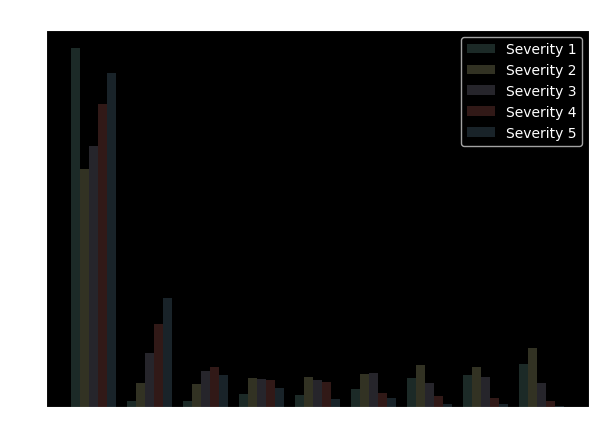

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({"figure.figsize":(7,5), "figure.dpi":100})

bins = np.linspace(0,1,10)

plt.hist([[s.severity_chances[i] for s in solutions] for i in range(1,6)], bins, alpha=0.2, label=[f"Severity {i}" for i in range(1,6)])
# plt.hist(human, bins, alpha=0.5, label="human")
# plt.hist(ai, bins, alpha=0.5, label="ai")
plt.xticks(np.arange(0,1,0.1))
plt.legend(loc="upper right")
plt.title(f"{len(solutions)} samples of <probability of successful attack> at each severity")
plt.show()
# plt.gca().set(title="Freq histogram", ylabel="Freq")

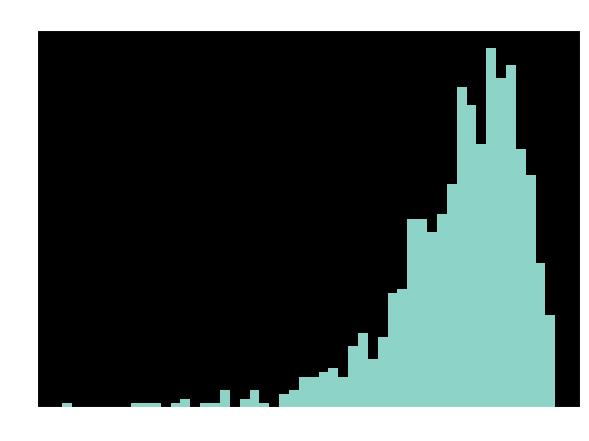

In [ ]:
plt.hist([s.defender_util for s in solutions], bins=50)
plt.title("Sample of defender utility")
plt.show()

In [ ]:
import json
# def _default(self, obj):
#     return getattr(obj, "to_json", _default.default)(obj)
# _default.default = json.JSONEncoder().default
# json.JSONEncoder.default = _default
with open("solutions.json","w") as f:
    json.dump(solutions, f, default=vars)